# matmul Behavior

Goal of this notebook is to convince ourselves that a `matmul` can only run on a Tenstorrent device if the inputs are:
1. At least 2-dimensional tensors
2. The tensors are in `TILE_LAYOUT`
3. (not a hard req) The tensors are in `bfloat16` data type

### Setup Environment

1. Setup the environment for tracing by configuring the `TTNN_CONFIG_OVERRIDES` environment variable
2. Import required libraries `torch`, `ttnn` and tracer related modules

In [1]:
import os

os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

In [3]:
import torch
import ttnn
from ttnn.tracer import visualize, trace

### Grab Device Handle

In [4]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                 Device | INFO     | Opening user mode device driver
2025-05-04 08:29:30.325 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-05-04 08:29:30.347 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-04 08:29:30.351 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-05-04 08:29:30.352 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-04 08:29:30.353 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-05-04 08:29:30.353 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-05-04 08:29:30.444 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


### Create Input Tensors

We'll create and trace 2 input tensors to be used to demonstrate the operations. First, we want to show that the input tensors are in `ROW_MAJOR_LAYOUT`

2025-05-04 08:35:55.902 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-04 08:35:55.906 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

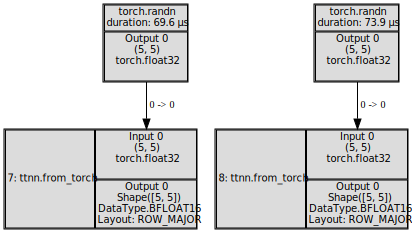

In [8]:
with trace():
    a = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16
    )
    b = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16
    )

visualize(a)
visualize(b)

Send the tensors to the device.

2025-05-04 08:36:35.315 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-04 08:36:35.318 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::BorrowedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device
                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::BorrowedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device


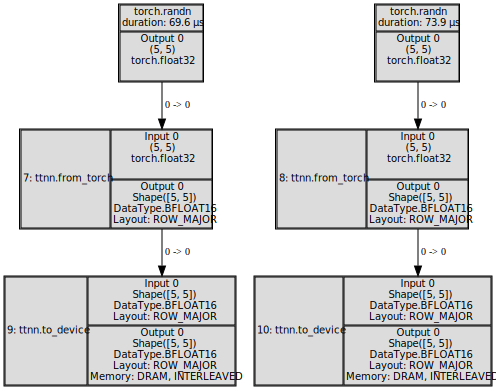

In [9]:
with trace():
    a = ttnn.to_device(a, device)
    b = ttnn.to_device(b, device)

visualize(a)
visualize(b)

At this point, the tensors `a` and `b` are in device storage (GDDR6 RAM), and in `bfloat16`. Most importantly both tensors are also in `ROW_MAJOR_LAYOUT`.

We will now attempt to perform a `matmul` on these tensors. And let's see what happens...

In [10]:
with trace():
    c = ttnn.matmul(a, b)

visualize(c)
print(c)

                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulM

RuntimeError: TT_FATAL @ /work/ttnn/cpp/ttnn/operations/matmul/device/matmul_op.cpp:1417: (input_tensor_a.get_layout() == Layout::TILE && input_tensor_b.get_layout() == Layout::TILE)
info:
Inputs to matmul must be tilized
backtrace:
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xf2f318) [0x7a45b8d2f318]
 --- ttnn::operations::matmul::Matmul::validate(std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&) const
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b843f) [0x7a45b9eb843f]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b83b7) [0x7a45b9eb83b7]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail23launch_on_worker_threadIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEENS3_3stl10StrongTypeIhNS_10QueueIdTagEEElNS5_15DeviceOperationISC_EENSD_13tensor_args_tESC_PNS4_7IDeviceEEEvT0_T1_RKT2_RKT3_RT4_RT5_+0x23e) [0x7a45bae07cde]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail23launch_on_single_deviceIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEEEENT_21tensor_return_value_tENS3_3stl10StrongTypeIhNS_10QueueIdTagEEERKNSE_22operation_attributes_tERKNSE_13tensor_args_tE+0x83) [0x7a45bae079f3]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x30078ea) [0x7a45bae078ea]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail6invokeIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEEEENT_21tensor_return_value_tENS3_3stl10StrongTypeIhNS_10QueueIdTagEEERKNSE_22operation_attributes_tERKNSE_13tensor_args_tE+0x197) [0x7a45bae072a7]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x3006c5b) [0x7a45bae06c5b]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x300693b) [0x7a45bae0693b]
 --- std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> tt::tt_metal::operation::run<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>(tt::tt_metal::operation::DeviceOperation<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>&&, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&, tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>)
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b7e68) [0x7a45b9eb7e68]
 --- void tt::tt_metal::operation::launch_op_func<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>(std::__1::function<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> (std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&)> const&, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>>, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>>)
 --- ttnn::operations::matmul::matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>, std::__1::optional<tt::tt_metal::Tensor> const&)
 --- ttnn::operations::matmul::bound_matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, unsigned char const&, std::__1::optional<tt::tt_metal::Tensor>&)
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn10operations6matmul15MatmulOperation6invokeERKN2tt8tt_metal6TensorES7_bbRKNSt3__18optionalIKNS4_12MemoryConfigEEENS9_IKNS4_8DataTypeEEERKNS9_IKNS8_7variantIJNS1_28MatmulMultiCoreProgramConfigENS1_45MatmulMultiCoreNonOptimizedReuseProgramConfigENS1_33MatmulMultiCoreReuseProgramConfigENS1_42MatmulMultiCoreReuseMultiCastProgramConfigENS1_44MatmulMultiCoreReuseMultiCast1DProgramConfigENS1_53MatmulMultiCoreReuseMultiCastDRAMShardedProgramConfigEEEEEERKNS9_IKNS8_12basic_stringIcNS8_11char_traitsIcEENS8_9allocatorIcEEEEEENS9_IKNSI_IJNS_28GrayskullComputeKernelConfigENS_27WormholeComputeKernelConfigEEEEEENS9_IKNS_5types8CoreGridEEERKNS9_IKNS4_4TileEEENS9_IS5_EERKNS9_IKNSI_IJNS8_9monostateENS4_12experimental20GlobalCircularBufferENS_22global_circular_buffer31MultiDeviceGlobalCircularBufferEEEEEERKNS9_INS3_3stl10StrongTypeIhNS4_14SubDeviceIdTagEEEEE+0x367) [0x7a45b9e9ffa7]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16e03d3) [0x7a45b94e03d3]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc47b) [0x7a45b94bc47b]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc2ab) [0x7a45b94bc2ab]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xecbfa9) [0x7a45b8ccbfa9]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x119c33) [0x7a45ee519c33]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x7a45ee4cb422]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce0aa) [0x7a45ee4ce0aa]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x13c5da) [0x7a45ee53c5da]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_Call+0x5d) [0x7a45ee4cb1bd]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_FastCallDictTstate+0x6b) [0x7a45ee4cb57b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_Call_Prepend+0x110) [0x7a45ee4cb8c0]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x13c608) [0x7a45ee53c608]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x7a45ee4cb422]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7559) [0x7a45ee472b99]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x7a45ee5c5962]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1be6d1) [0x7a45ee5be6d1]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a421) [0x7a45ee51a421]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe239e) [0x7a45ee4e239e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xd5a0d) [0x7a45ee4d5a0d]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyVectorcall_Call+0xd0) [0x7a45ee4cb080]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6857) [0x7a45ee471e97]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0x9c11) [0x7a45ec79fc11]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0xa7af) [0x7a45ec7a07af]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a00e) [0x7a45ee51a00e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1dc74b) [0x7a45ee5dc74b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a299) [0x7a45ee51a299]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7518) [0x7a45ee472b58]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x7a45ee5c5962]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1be6d1) [0x7a45ee5be6d1]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a421) [0x7a45ee51a421]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x22e06a) [0x7a45ee62e06a]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(Py_RunMain+0x362) [0x7a45ee62e622]


Okay, an exception occurred because our tensors are not in the proper `TILE_LAYOUT`. It crashed, so lets clean up by closing the device and then opening again.

In [11]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


Disable tracing too...

In [12]:
ttnn.tracer.disable_tracing()

### Operating in TILE_LAYOUT

Now, we will explore multiplying tensors in `TILE_LAYOUT`. This is the expected layout for operations like `matmul` performed on the device.

In [13]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz


2025-05-04 08:47:32.454 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-04 08:47:32.457 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

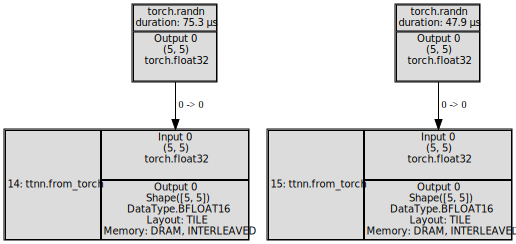

In [15]:
with trace():
    a = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16,
        layout=ttnn.TILE_LAYOUT,
        device=device
    )
    b = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16,
        layout=ttnn.TILE_LAYOUT,
        device=device
    )

visualize(a)
visualize(b)


2025-05-04 08:49:09.720 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulM

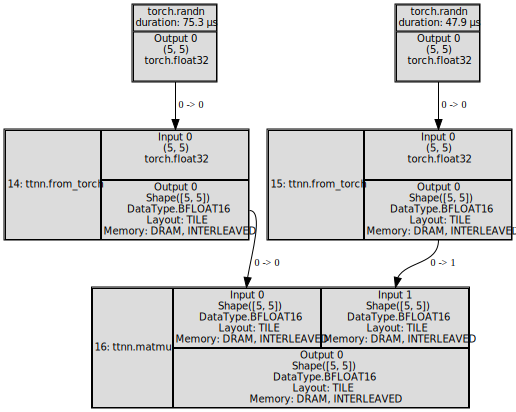

In [16]:
with trace():
    c = ttnn.matmul(a, b)

visualize(c)

In [17]:
c

ttnn.Tensor([[-2.76562,  2.78125,  ..., -1.10938, -0.34180],
             [ 0.19922, -1.42188,  ...,  1.13281,  2.04688],
             ...,
             [ 0.52344, -0.10205,  ...,  0.72266,  1.21875],
             [ 1.85938, -0.31055,  ...,  0.02979, -1.05469]], shape=Shape([5, 5]), dtype=DataType::BFLOAT16, layout=Layout::TILE)

                 Always | INFO     | Begin op: Tensor::cpu
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool>
                 Always | INFO     | End op: Tensor::cpu
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | Begin op: ttnn::to_layout
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Layout>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::nullopt_t const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::nullopt_t const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO 

Let's move the tensor from Tenstorrent hardware back to the CPU. This tensor will still be a `ttnn` tensor.

2025-05-04 08:52:39.968 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: Tensor::cpu
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool>
                 Always | INFO     | Begin op: Tensor::cpu
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool>
                 Always | INFO     | End op: Tensor::cpu
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | End op: Tensor::cpu
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage


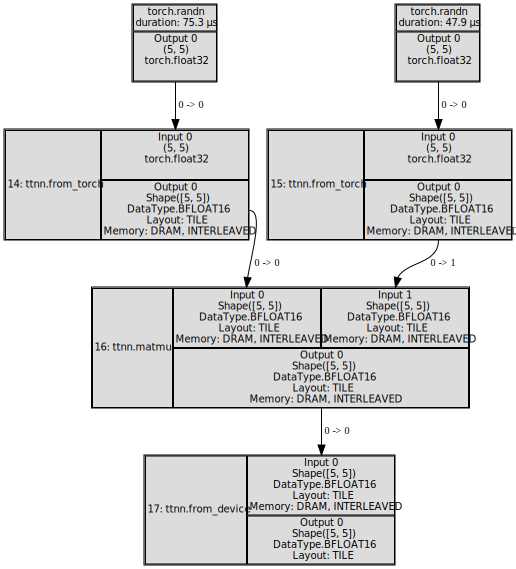

In [18]:
with trace():
    c = ttnn.from_device(c)

visualize(c)

Let's convert the ttnn tensor back to a torch tensor

2025-05-04 08:54:26.569 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: Tensor::to_layout
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Layout>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | Begin op: Tensor::to_layout
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Layout>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | End op: Tensor::to_layout
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 A

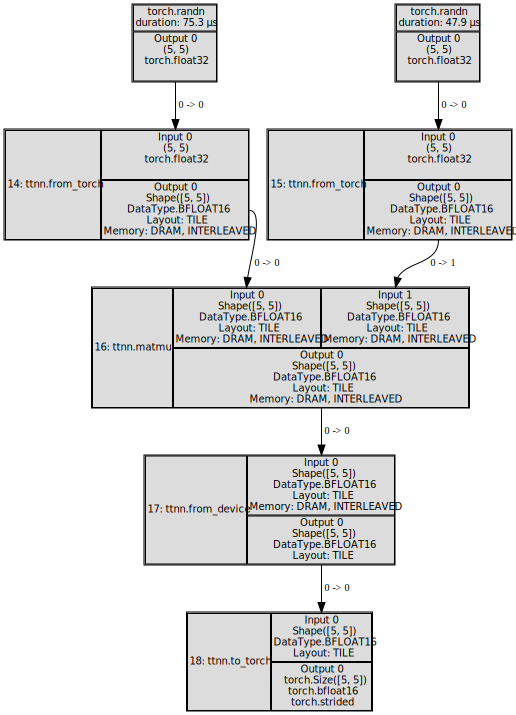

In [19]:
with trace():
    c = ttnn.to_torch(c)

visualize(c)

In [20]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


### Attempt to matmul on Tensors not in Tenstorrent Hardware

Let's see what kind of error we get if we attempt to `matmul` on tensors NOT on the device, but still living in CPU.

2025-05-04 08:57:22.607 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-04 08:57:22.610 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

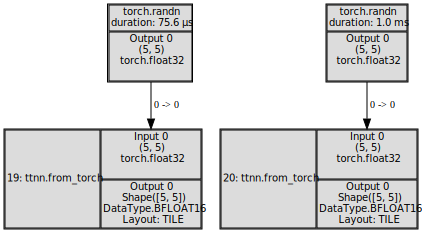

In [21]:
with trace():
    a = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16,
        layout=ttnn.TILE_LAYOUT
    )
    b = ttnn.from_torch(
        torch.randn(5, 5),
        dtype=ttnn.bfloat16,
        layout=ttnn.TILE_LAYOUT
    )

visualize(a)
visualize(b)

Attempt to matmul:

In [22]:
with trace():
    c = ttnn.matmul(a, b)

visualize(c)

                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmu

RuntimeError: TT_THROW @ /work/ttnn/cpp/ttnn/tensor/tensor.hpp:331: tt::exception
info:
Cannot get the device from a tensor with host storage
backtrace:
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xf2f318) [0x7a45b8d2f318]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xfb7451) [0x7a45b8db7451]
 --- ttnn::operations::matmul::create_matmul_struct(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, ttnn::operations::matmul::Matmul const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&)
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b7cdd) [0x7a45b9eb7cdd]
 --- void tt::tt_metal::operation::launch_op_func<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>(std::__1::function<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> (std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&)> const&, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>>, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>>)
 --- ttnn::operations::matmul::matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>, std::__1::optional<tt::tt_metal::Tensor> const&)
 --- ttnn::operations::matmul::bound_matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, unsigned char const&, std::__1::optional<tt::tt_metal::Tensor>&)
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn10operations6matmul15MatmulOperation6invokeERKN2tt8tt_metal6TensorES7_bbRKNSt3__18optionalIKNS4_12MemoryConfigEEENS9_IKNS4_8DataTypeEEERKNS9_IKNS8_7variantIJNS1_28MatmulMultiCoreProgramConfigENS1_45MatmulMultiCoreNonOptimizedReuseProgramConfigENS1_33MatmulMultiCoreReuseProgramConfigENS1_42MatmulMultiCoreReuseMultiCastProgramConfigENS1_44MatmulMultiCoreReuseMultiCast1DProgramConfigENS1_53MatmulMultiCoreReuseMultiCastDRAMShardedProgramConfigEEEEEERKNS9_IKNS8_12basic_stringIcNS8_11char_traitsIcEENS8_9allocatorIcEEEEEENS9_IKNSI_IJNS_28GrayskullComputeKernelConfigENS_27WormholeComputeKernelConfigEEEEEENS9_IKNS_5types8CoreGridEEERKNS9_IKNS4_4TileEEENS9_IS5_EERKNS9_IKNSI_IJNS8_9monostateENS4_12experimental20GlobalCircularBufferENS_22global_circular_buffer31MultiDeviceGlobalCircularBufferEEEEEERKNS9_INS3_3stl10StrongTypeIhNS4_14SubDeviceIdTagEEEEE+0x367) [0x7a45b9e9ffa7]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16e03d3) [0x7a45b94e03d3]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc47b) [0x7a45b94bc47b]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc2ab) [0x7a45b94bc2ab]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xecbfa9) [0x7a45b8ccbfa9]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x119c33) [0x7a45ee519c33]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x7a45ee4cb422]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce0aa) [0x7a45ee4ce0aa]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x13c5da) [0x7a45ee53c5da]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_Call+0x5d) [0x7a45ee4cb1bd]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_FastCallDictTstate+0x6b) [0x7a45ee4cb57b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_Call_Prepend+0x110) [0x7a45ee4cb8c0]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x13c608) [0x7a45ee53c608]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x7a45ee4cb422]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7559) [0x7a45ee472b99]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x7a45ee5c5962]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1be6d1) [0x7a45ee5be6d1]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a421) [0x7a45ee51a421]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe239e) [0x7a45ee4e239e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xd5a0d) [0x7a45ee4d5a0d]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyVectorcall_Call+0xd0) [0x7a45ee4cb080]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6857) [0x7a45ee471e97]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x775b) [0x7a45ee472d9b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xe167e) [0x7a45ee4e167e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0x9c11) [0x7a45ec79fc11]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0xa7af) [0x7a45ec7a07af]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a00e) [0x7a45ee51a00e]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1dc74b) [0x7a45ee5dc74b]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a299) [0x7a45ee51a299]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x4b88) [0x7a45ee4701c8]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x710f) [0x7a45ee47274f]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0xce050) [0x7a45ee4ce050]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7518) [0x7a45ee472b58]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x7a45ee5c5962]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1be6d1) [0x7a45ee5be6d1]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x11a421) [0x7a45ee51a421]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x66c6) [0x7a45ee471d06]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x1c5b34) [0x7a45ee5c5b34]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(+0x22e06a) [0x7a45ee62e06a]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(Py_RunMain+0x362) [0x7a45ee62e622]
 --- /home/avgdev/.pyenv/versions/3.10.11/lib/libpython3.10.so.1.0(Py_BytesMain+0x5e) [0x7a45ee62f02e]
 --- /lib/x86_64-linux-gnu/libc.so.6(+0x2a1ca) [0x7a45ee02a1ca]
 --- /lib/x86_64-linux-gnu/libc.so.6(__libc_start_main+0x8b) [0x7a45ee02a28b]
 --- /home/avgdev/code/avg-dev/projects/python/ttnn-sandbox/.venv/bin/python(_start+0x25) [0x56fd7776e095]
